In [532]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import seaborn as sns

from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA

from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

In [539]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [441]:
data = np.load('data.npy')
df = pd.read_csv('./MNSite3Synaptograms.csv', header=1, index_col=0)

In [442]:
data.shape

(1078, 8, 11, 11, 11)

In [443]:
X = data.copy()
y = df['GABA'].values

In [424]:
def resample_data(X, y, n_samples, mode):
    """
    Mode = 'downsample' or 'upsample'
    """
    
    X_ = X.copy()
    if (y==0).sum() > (y==1).sum():
        X_major = X_[y==0]
        X_minor = X_[y==1]
    else:
        X_major = X_[y==1]
        X_minor = X_[y==0]
    
    if mode == 'upsample':
        X_minor = resample(X_minor, n_samples=n_samples, replace=True)
    elif mode == 'downsample':
        X_major = resample(X_major, n_samples=n_samples, replace=False)
        
    X_ = np.vstack((X_minor, X_major))
    y_ = np.zeros(len(X_minor) + len(X_major), dtype=np.int)
    y_[:len(X_minor)] = 1
    
    return X_, y_

In [435]:
def normalize_data(X1, X2):
    """
    Expects data in shape (n_samples, channels, z, y, x)
    """
    X1_ = X1.copy()
    X1_ = (X1_ - X1_.mean(axis=(0, 2, 3, 4), keepdims=True)) / X1_.std(axis=(0, 2, 3, 4), keepdims=True)
    
    X2_ = X2.copy()
    X2_ = (X2_ - X2_.mean(axis=(0, 2, 3, 4), keepdims=True)) / X2_.std(axis=(0, 2, 3, 4), keepdims=True)

    return X1_, X2_

In [630]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=20)
cm = []

for train_idx, test_idx in kfold.split(X, y):
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = normalize_data(X[train_idx], X[test_idx])
    
    X_train, y_train = resample_data(X_train, y_train, 300, 'upsample')
    X_train, y_train = resample_data(X_train, y_train, 301, 'downsample')
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred, ))

Confusion matrix, without normalization
[[0.97802083 0.02197917]
 [0.39306159 0.60693841]]


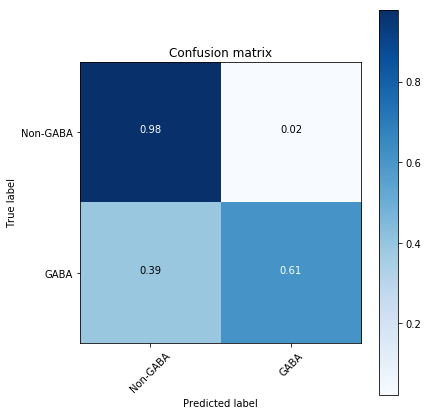

In [631]:
mu, std = compute_cm(cm)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(mu, ['Non-GABA', 'GABA'])
plt.show()

Confusion matrix, without normalization
[[0.00568162 0.00568162]
 [0.11436623 0.11436623]]


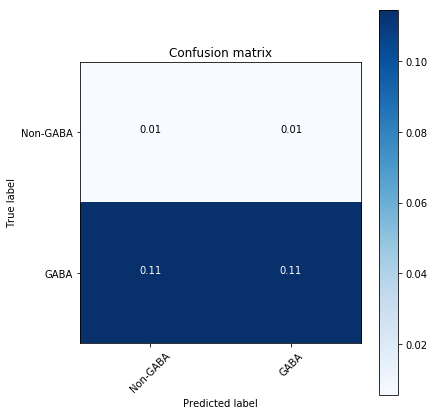

In [626]:
plt.figure(figsize=(6, 6))
plot_confusion_matrix(std, ['Non-GABA', 'GABA'])
plt.show()

In [598]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=20)
cm = []

for train_idx, test_idx in kfold.split(X, y):
    y_train, y_test = y[train_idx], y[test_idx]
    #X_train, X_test = X[train_idx], X[test_idx]
    X_train, X_test = normalize_data(X[train_idx], X[test_idx])

    #X_train, y_train = resample_data(X_train, y_train, 200, 'upsample')
    #X_train, y_train = resample_data(X_train, y_train, 300, 'downsample')
    
    X_train = X_train.reshape((len(X_train), -1))
    X_test = X_test.reshape((len(X_test), -1))
    
    rf = RandomForestClassifier(class_weight='balanced')
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    cm.append(confusion_matrix(y_test, pred, ))

In [595]:
def compute_cm(cm):
    arr = np.array(cm)
    arr = arr.astype('float') / arr.sum(axis=(2), keepdims=True)
    arr_mean = arr.mean(axis=0)
    arr_std = arr.std(axis=0)
    
    return arr_mean, arr_std

Confusion matrix, without normalization
[[0.99791667 0.00208333]
 [0.83030797 0.16969203]]


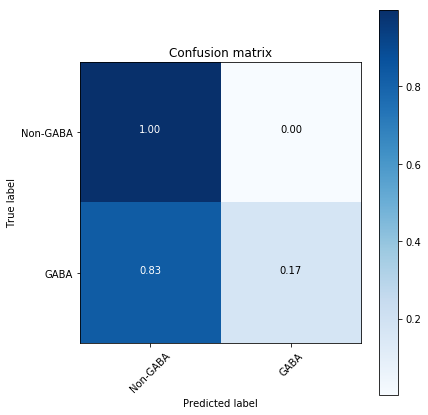

In [599]:
mu, std = compute_cm(cm)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(mu, ['Non-GABA', 'GABA'])
plt.show()

Confusion matrix, without normalization
[[0.00345482 0.00345482]
 [0.08687838 0.08687838]]


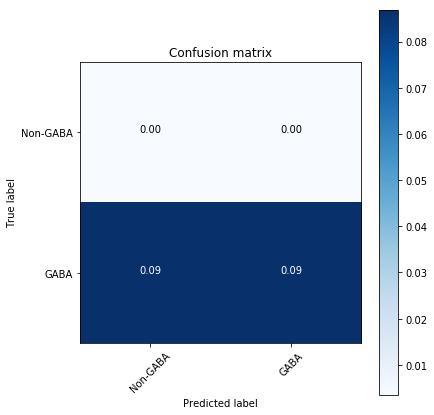

In [600]:
plt.figure(figsize=(6, 6))
plot_confusion_matrix(std, ['Non-GABA', 'GABA'])
plt.show()